# Notebook 5 - Finding cloud frequency using spectral thresholds

Using Notebook 4 (goes_eval_w_camera), we have found a combination of thresholds using a decision tree to identify cloudy vs. clear pixels in GOES data.

In [1]:
import pandas as pd
import numpy as np
import rasterio
import geopandas as gpd
from matplotlib.colors import LightSource
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Calculate cloud frequency and sum monthly

In [2]:
def daily_cloud_frequency(year, month, state, goes):
    if month == '07' or month == '08':
        start_day = 1
        end_day = 32
    elif month == '06' or month == '09':
        start_day = 1
        end_day = 31

    
    for day in range(start_day, end_day):    
        date = f'{year}{month}' + str(day).zfill(2)
        path = f'/storage/cdalden/goes/{state}/{goes}/rgb_composite/'
        file = f'{goes}_C02_C05_C13_rgb_{state}_{date}.nc'.format(date=date)

        ds = xr.open_dataset(path + file)

        # Make mask for cloud/no cloud
        clouds = xr.where((ds.blue >= 0.13) & (ds.green >= 0.15), 1, 0) # cloud (1) if all conds are met, not cloud (0) otherwise
        ds['clouds'] = clouds

        # Select the time range between 0000-0300 and 1400-2359
        cloud_frequency = ds.clouds.sel(
            t=((ds['t'].dt.hour >= 0) & (ds['t'].dt.hour < 3)) | (ds['t'].dt.hour >= 14)
        ).sum(dim='t')
        cloud_counts = xr.Dataset(
            {'cloud_frequency': (['latitude', 'longitude'], cloud_frequency.data)},
            coords={'latitude': ds.latitude, 'longitude': ds.longitude}
        )

        # Save the cloud frequency data to a NetCDF file
        out_path = f'/storage/cdalden/goes/{state}/{goes}/cloud_counts/'
        out_file = f'{goes}_cloud_frequency_{state}_{date}.nc'.format(date=date)
        cloud_counts.to_netcdf(out_path + out_file)
        print(f"Processed and saved cloud frequency for {date}")

In [3]:
def process_monthly_data(year, month, state, goes, save_file=False):
    
    if month == '07' or month == '08':
        start_day = 1
        end_day = 32
    elif month == '06' or month == '09':
        start_day = 1
        end_day = 31

    # Define the date range and file path
    path = f'/storage/cdalden/goes/{state}/{goes}/cloud_counts/'
    file_name_template = f'{goes}_cloud_frequency_{state}_' + '{date}.nc'

    # Generate the list of file paths and corresponding times
    file_paths = []
    times = []
    for day in range(start_day, end_day):  # Days 1 to 30
        date = f'{year}{month}{str(day).zfill(2)}'  # Format the date as '202209DD'
        file_paths.append(path + file_name_template.format(date=date))
        times.append(pd.Timestamp(f'{year}-{month}-{str(day).zfill(2)}'))  # Create a timestamp for each day

    # Open all files and add the time dimension
    datasets = []
    for file, time in zip(file_paths, times):
        ds = xr.open_dataset(file)
        ds = ds.expand_dims(time=[time])  # Add the time dimension
        datasets.append(ds)

    # Combine all datasets along the time dimension
    combined_ds = xr.concat(datasets, dim='time')

    # Compute the sum across the time dimension
    monthly_sum = combined_ds['cloud_frequency'].sum(dim='time')

    # Add the monthly sum as a new variable to the dataset
    combined_ds['monthly_sum'] = monthly_sum

    # monthly frequency 
    combined_ds['monthly_frequency'] = combined_ds['monthly_sum'] / (156*30)  # Assuming 156 observations per day for 30 days

    if save_file:
        combined_ds.to_netcdf(path + f'{goes}_monthly_cloud_frequency_{state}_{year}{month}.nc')
        print(f"Saved monthly cloud frequency data for month {month}")
    
    return combined_ds


### Run the functions

In [6]:
year = '2022'
state = 'washington'
goes = 'goes17'
# months_list = ['06', '07', '08', '09']
months_list = ['08']
for month in months_list:
    daily_cloud_frequency(year,month, state, goes)

Processed and saved cloud frequency for 20220801
Processed and saved cloud frequency for 20220802
Processed and saved cloud frequency for 20220803
Processed and saved cloud frequency for 20220804
Processed and saved cloud frequency for 20220805
Processed and saved cloud frequency for 20220806
Processed and saved cloud frequency for 20220807
Processed and saved cloud frequency for 20220808
Processed and saved cloud frequency for 20220809
Processed and saved cloud frequency for 20220810
Processed and saved cloud frequency for 20220811
Processed and saved cloud frequency for 20220812
Processed and saved cloud frequency for 20220813
Processed and saved cloud frequency for 20220814
Processed and saved cloud frequency for 20220815
Processed and saved cloud frequency for 20220816
Processed and saved cloud frequency for 20220817
Processed and saved cloud frequency for 20220818
Processed and saved cloud frequency for 20220819
Processed and saved cloud frequency for 20220820
Processed and saved 

In [7]:
# Define the months and their corresponding variable names
months_dict = {'06': 'jun_cloud_freq', '07': 'jul_cloud_freq', 
               '08': 'aug_cloud_freq', '09': 'sep_cloud_freq'}
# Dictionary to store the datasets
cloud_freq_datasets = {}

# Loop through the months and process the data
for month, var_name in months_dict.items():
    ds = process_monthly_data(year, month, state, goes, save_file=True)  # Process the data for the month
    cloud_freq_datasets[var_name] = ds  # Save the dataset with the variable name as the key

# Access the datasets
jun_cloud_freq = cloud_freq_datasets['jun_cloud_freq']
jul_cloud_freq = cloud_freq_datasets['jul_cloud_freq']
aug_cloud_freq = cloud_freq_datasets['aug_cloud_freq']
sep_cloud_freq = cloud_freq_datasets['sep_cloud_freq']


Saved monthly cloud frequency data for month 06
Saved monthly cloud frequency data for month 07
Saved monthly cloud frequency data for month 08


FileNotFoundError: [Errno 2] No such file or directory: '/storage/cdalden/goes/washington/goes17/cloud_counts/goes17_cloud_frequency_washington_20220901.nc'

In [6]:
# sep_minus_aug = sep_cloud_freq['monthly_frequency'] - aug_cloud_freq['monthly_frequency']
aug_minus_jul = aug_cloud_freq['monthly_frequency'] - jul_cloud_freq['monthly_frequency']

## Plots

In [22]:
# Path to the DEM file
dem_path = "nasa_colorado_dem.tif"

# Open the DEM file
with rasterio.open(dem_path) as src:
    elevation = src.read(1)  # Read the first band (elevation data)
    bounds = src.bounds      # Get the bounds of the DEM
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]


# subset DEM for East River
bbox = [-107.4, -106.7, 38.7, 39.3]
with rasterio.open(dem_path) as src:
    window = rasterio.windows.from_bounds(bbox[0], bbox[2], bbox[1], bbox[3], transform=src.transform)
    er_elevation = src.read(1, window=window)
    cropped_bounds = rasterio.windows.bounds(window, transform=src.transform)

In [23]:
with rasterio.open(dem_path) as src:
    print(src.crs)

EPSG:4326


In [24]:
east_river = gpd.read_file('/home/cdalden/goes_work/analysis/east_polygon.json', driver='GeoJSON')

# Ensure the GeoDataFrame is in the correct CRS (latitude/longitude)
if east_river.crs is None or east_river.crs.to_string() != "EPSG:4326":
    east_river = east_river.to_crs(epsg=4326)

/home/cdalden/miniforge3/envs/goes_env/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(


/tmp/ipykernel_1112588/686149792.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  shaded = ls.shade(elevation, cmap=cm.get_cmap("Greys"), vert_exag=1, blend_mode="overlay")


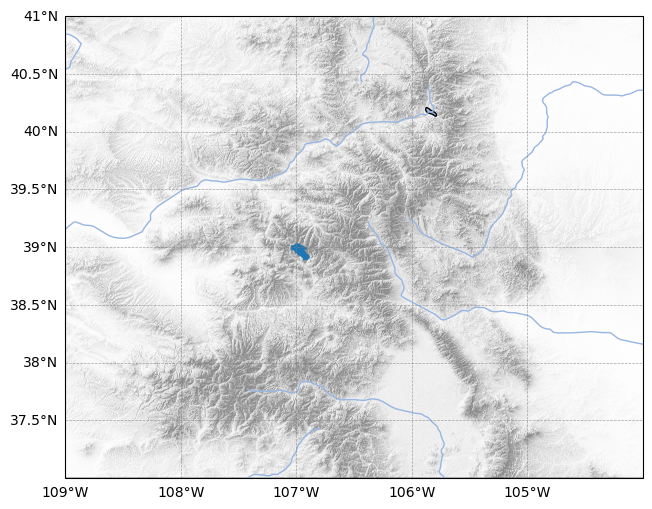

In [26]:
# Create the plot with Cartopy projection
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

east_river.plot(ax=ax)

# Generate terrain shading
ls = LightSource(azdeg=315, altdeg=45)  # Azimuth and altitude of the light source
shaded = ls.shade(elevation, cmap=cm.get_cmap("Greys"), vert_exag=1, blend_mode="overlay")

# Plot the shaded terrain
ax.imshow(
    shaded,
    extent=extent,  # Ensure extent matches the geographic bounds of the data
    transform=ccrs.PlateCarree(),
    origin="upper",
    alpha=0.5
)

# Add state outlines and coastlines
ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor="black")
ax.add_feature(cfeature.RIVERS)
# Add gridlines with latitude and longitude labels
gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gridlines.top_labels = False  # Disable top labels
gridlines.right_labels = False  # Disable right labels
gridlines.xlabel_style = {'size': 10, 'color': 'black'}
gridlines.ylabel_style = {'size': 10, 'color': 'black'}

# ax.set_extent([-108, -106, 38, 40], crs=ccrs.PlateCarree())  # east riverish extent


### Notes

use pygeohydro package to add shapefile of East river bounds

add hillshade using py3dep within above package

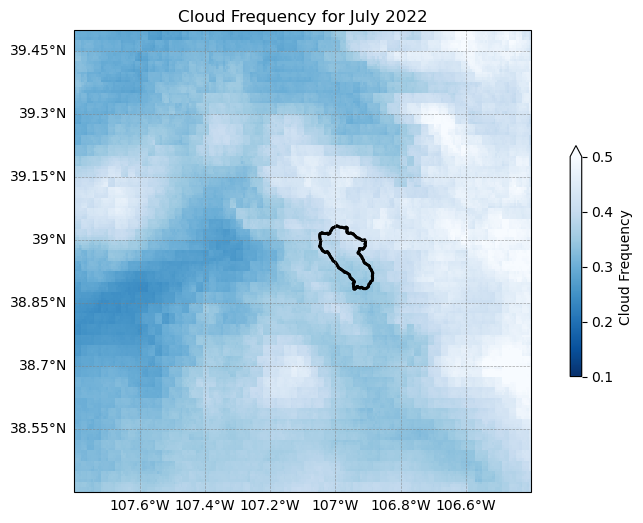

In [28]:
# Create the plot with Cartopy projection
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use PlateCarree for geographic data

# Plot the data
jul_cloud_freq.monthly_frequency.plot(
    ax=ax, 
    cmap="Blues_r",  
    transform=ccrs.PlateCarree(),  # Specify the data's coordinate system
    cbar_kwargs={'label': 'Cloud Frequency', 'shrink': 0.5},
    vmin=0.1, vmax=0.5  # Set color scale limits
)

# plot east river bounds
east_river.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=2, zorder=1, transform=ccrs.PlateCarree())

# # Generate terrain shading
# ls = LightSource(azdeg=315, altdeg=45)  # Azimuth and altitude of the light source
# shaded = ls.shade(elevation_data, cmap=cm.get_cmap("Greys"), vert_exag=1, blend_mode="overlay")

# # Plot the shaded terrain
# ax.imshow(
#     shaded,
#     extent=extent,  # Ensure extent matches the geographic bounds of the data
#     transform=ccrs.PlateCarree(),
#     origin="upper",
#     alpha=0.5
# )

# # Add elevation contours
# contour_levels = np.arange(1000, 4000, 250)  # Define contour levels (e.g., 1000m to 4000m)
# contour = ax.contour(
#     er_elevation, 
#     levels=contour_levels, 
#     colors='black', 
#     linewidths=0.8, 
#     transform=ccrs.PlateCarree(), 
#     extent=extent,
#     alpha=0.5  # Set transparency for contours
# )
# ax.clabel(contour, inline=True, fontsize=8, fmt='%d')  # Add labels to contours



# Add state outlines and coastlines
ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor="black")
ax.add_feature(cfeature.RIVERS)
# Add gridlines with latitude and longitude labels
gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gridlines.top_labels = False  # Disable top labels
gridlines.right_labels = False  # Disable right labels
gridlines.xlabel_style = {'size': 10, 'color': 'black'}
gridlines.ylabel_style = {'size': 10, 'color': 'black'}


# Add title and labels
plt.title(f"Cloud Frequency for July 2022")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

ax.set_extent([-107.8, -106.4, 38.4, 39.5], crs=ccrs.PlateCarree())  # east riverish extent

# Show the plot
plt.show()

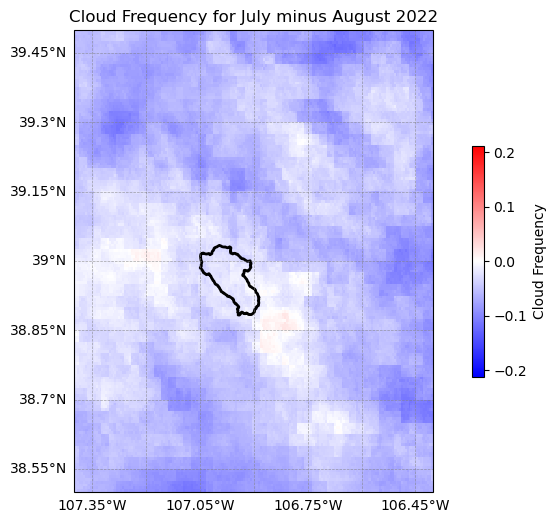

In [35]:
# Create the plot with Cartopy projection
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use PlateCarree for geographic data

# Plot the cloud frequency data
aug_minus_jul.plot(
    ax=ax, 
    cmap="bwr",  
    transform=ccrs.PlateCarree(),  # Specify the data's coordinate system
    cbar_kwargs={'label': 'Cloud Frequency', 'shrink': 0.5}
)

# plot east river bounds
east_river.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=2, zorder=1, transform=ccrs.PlateCarree())


# # Add elevation contours
# contour_levels = np.arange(1000, 4000, 500)  # Define contour levels (e.g., 1000m to 4000m)
# elevation_masked = np.ma.masked_invalid(elevation)  # Mask invalid elevation values
# contour = ax.contour(
#     elevation_masked, 
#     levels=contour_levels, 
#     colors='black', 
#     linewidths=0.8, 
#     transform=ccrs.PlateCarree(), 
#     extent=extent,
#     alpha=0.5  # Set transparency for contours
# )
# ax.clabel(contour, inline=True, fontsize=8, fmt='%d')  # Add labels to contours


# Add state outlines and coastlines
ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='black')
# Add gridlines with latitude and longitude labels
gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gridlines.top_labels = False  # Disable top labels
gridlines.right_labels = False  # Disable right labels
gridlines.xlabel_style = {'size': 10, 'color': 'black'}
gridlines.ylabel_style = {'size': 10, 'color': 'black'}


# Add title and labels
plt.title(f"Cloud Frequency for July minus August 2022")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

ax.set_extent([-107.4, -106.4, 38.5, 39.5], crs=ccrs.PlateCarree())  # east riverish extent


# ax.text(-107.3, 39.4, 'East River Basin', fontsize=10, transform=ccrs.PlateCarree(), zorder=2)

# Show the plot
plt.show()